In [89]:
%load_ext autoreload
%autoreload

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D, concatenate, AveragePooling1D, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy, Reduction, BinaryCrossentropy
from tensorflow.keras.layers import Lambda
from tensorflow.keras.activations import softmax
from tensorflow import roll, norm, add
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.applications as A
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import fnmatch
import cv2
import json

import include.supervisely_parser as svp
import include.grid_parser as gp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
annotation_path = './annotation_v0.1/'
image_path = './data/Mikrowunderland_1k/'
number_classes = 4 # outer_l, outer_t, outer_r, middle_curb
x_values = 240
y_values = 60

input_width = 434
input_height = 150

In [86]:
images = []
segmented_debug = []
data = []

def preprocess(img):
    height, _, _ = img.shape
    img = img[int(height/2):,:,:]
    return img
def preprocess_gray(img):
    height, _ = img.shape
    img = img[int(height/2):,:]
    return img
def debug_image_from_grid_channel(grid):
    img = np.zeros((y_values, x_values))
    for y in range(len(grid)):
        non_zero = np.nonzero(grid[y])
        for x in non_zero:
            img[y, x] = 1.0
    return img

file_list = os.listdir(annotation_path)
pattern = '*.json'
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        ann_data_path = os.path.join(annotation_path, filename)
        image_name = os.path.splitext(filename)[0]
        image_data_path = os.path.join(image_path, image_name)
        
        # extract lanes from ann data
        lanes = svp.getPoints(ann_data_path)
        if len(lanes.keys()) > 0:
            # only if this image has annotation data
            img = cv2.imread(image_data_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            blank = np.zeros((number_classes, img.shape[0], img.shape[1]))
            segmented_data = svp.drawLanes(blank, lanes)
            segmented_debug_image = svp.drawDebugImage(np.zeros(img.shape), lanes)
            # preprocess both images
            data_entry = np.zeros((number_classes, int(img.shape[0]/2)+1, img.shape[1]))
            for i, grayscale_image in enumerate(segmented_data):
                data_entry[i] = preprocess_gray(grayscale_image)
            
            grid = gp.segmented_image_into_grid_space(data_entry, grid_size=(y_values, x_values), window_size_x=10)

            img = preprocess(img)
            segmented_debug_image = preprocess(segmented_debug_image)
            img = cv2.resize(img, (input_width, input_height))

            images.append(img)
            data.append(grid)
            segmented_debug.append(segmented_debug_image)


            
            


(4, 60, 240)


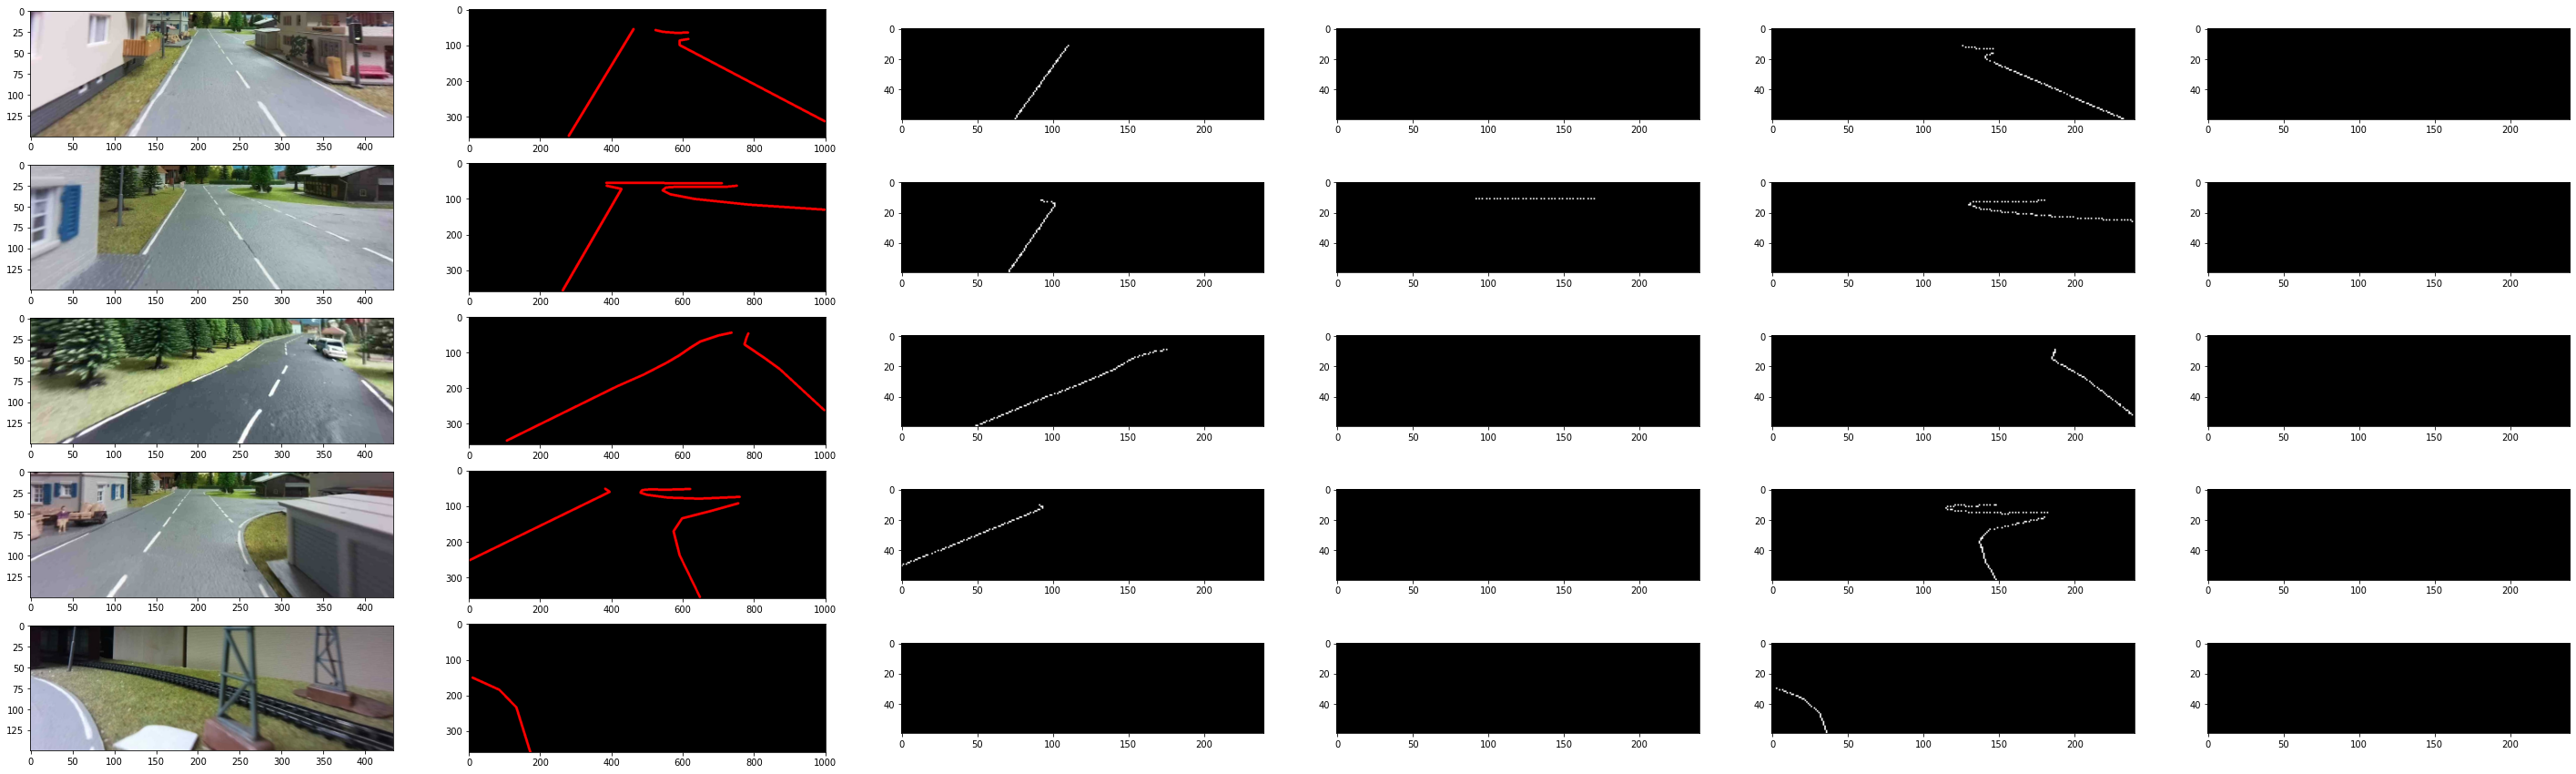

In [87]:
c = 5
f, axs = plt.subplots(c, 6, figsize=(50,c*3))
i = 0
print(data[i].shape)
for y in range(c):
    axs[y,0].imshow(images[i])
    axs[y,1].imshow(segmented_debug[i])
    axs[y,2].imshow(debug_image_from_grid_channel(data[i][0]), cmap='gray')
    axs[y,3].imshow(debug_image_from_grid_channel(data[i][1]), cmap='gray')
    axs[y,4].imshow(debug_image_from_grid_channel(data[i][2]), cmap='gray')
    axs[y,5].imshow(debug_image_from_grid_channel(data[i][3]), cmap='gray')
    i += 1

In [88]:
img_train, img_valid, data_train, data_valid = train_test_split(images, data, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(img_train), len(img_valid)))

Training data: 275
Validation data: 69


In [37]:
# LOSS FUNCTIONS
number_lanes = number_classes
num_rows = y_values
num_classes = x_values

def loss_cls(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    true_shaped = K.reshape(y_true, shape=(-1,number_lanes,num_rows, num_classes))
    pred_shaped = K.reshape(y_pred, shape=(-1,number_lanes,num_rows, num_classes))
    bce = BinaryCrossentropy(reduction=Reduction.SUM)
    bce_val = bce(true_shaped, pred_shaped)
    
    return bce_val

def loss_sim(y_true, y_pred):
    y_pred = K.cast(y_pred, 'float32')

    pred_shaped = K.reshape(y_pred, shape=(-1,number_lanes,num_rows, num_classes))
    pred_shaped_plus1 = roll(pred_shaped, shift=-1, axis=2)
    
    subtracted = pred_shaped - pred_shaped_plus1
    removed_last_row = Lambda(lambda x: x[:, :, :num_rows-1, :])(subtracted)
    
    l1_norm = norm(removed_last_row, ord=1, axis=-1, keepdims=False)
    lane_sum = K.sum(l1_norm, axis=2)
    return K.sum(lane_sum)

def loss_total(y_true, y_pred):
    cls_ = loss_cls(y_true, y_pred)
    sim_ = loss_sim(y_true, y_pred)
    return add(cls_,sim_)

In [38]:
def res_cls_model(total_dim, name):
    base_model = A.ResNet50V2(include_top=False, weights="imagenet", input_shape=(180,340,3)) 
    
    pool = Conv2D(8, (1, 1))(base_model.output)
    
    flatten = Flatten()(pool)
    
    cls_group = Dense(256, activation="relu")(flatten)
    cls_group = Dropout(0.4)(cls_group)
    cls_group = Dense(total_dim)(cls_group)
    
    output = Reshape((number_lanes,num_rows, num_classes))(cls_group)
    output = Activation('softmax')(output)
    
    model = Model(inputs=base_model.input, outputs=output, name=name)
    optimizer = Adam(lr=4e-4) # lr is learning rate
    model.compile(loss=loss_total, optimizer=optimizer) # mean squared error because it is a regression problem
    #plot_model(model, to_file='%s.png' % (name))
    return model
def pretrained_model():
    return load_model('ld_sim_base.h5', custom_objects={'loss_total': loss_total})
    #return load_model('ld_sim_base.h5', custom_objects={'loss_total': loss_total})
    
model = res_cls_model(np.prod((number_lanes,num_rows, num_classes)), 'AUTOSYS_LANEDETECTION_CLS')
#model = res_cls_model()
#print(model.summary())

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "AUTOSYS_LANEDETECTION_CLS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 340, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 346, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 170, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)

In [39]:
# Hyperparamter
my_batch_size = 8
my_epochs = 20
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(img_train, data_train,
                   batch_size=my_batch_size,
                   epochs=my_epochs,
                   verbose=1,
                   validation_data=(img_valid, data_valid),
                   callbacks=callbacks_list)

model.save('ld_autosys.h5')

ValueError: Data cardinality is ambiguous:
  x sizes: 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150
  y sizes: 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4
Make sure all arrays contain the same number of samples.